In [94]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
from utils import StockSpec, ConvertibleBondSpec, ForwardRates, Mapping, DataUtils
from STTstock import STTStock, Sensitivities, Valuation

# mtlb_model: Documentation

The code for this model is constituted of the following modules:
- utils: tools used for pricing. Contains the classes defining stocks, convertible bonds, forward interest rates model and mapping of indexes in the tree
- STTstock: trinomial tree model and sensitivities

___

# utils.py

### Testing: Mapping class

#### Mapping class

##### Purpose:
This class is used to perform a mapping between dates and indexes of the dates defined by steps in order to easily
work with indexes in the tree and dates (for instance, call and put dates, coupon dates) and speed up the code.

___
__Main functions__:
 - init: Require start date and end date of the period and a number of steps
 - get_mapping_from_dates: Create the mapping dictionary from dates to indexes
 - get_mapping_from_indexes: Create the mapping dictionary from indexes to dates

In [95]:
# testing the Mapping class
d1 = datetime.datetime(2016, 1, 1)
d2 = datetime.datetime(2018, 1, 10)
mapping = Mapping(startDate=d1, endDate=d2, nb_steps=500)
print('Length of time period: ', mapping.timeperiod)
print('Number of steps: ', mapping.nb_steps)
print('Length of time steps: ', mapping.timestep)

Length of time period:  740
Number of steps:  500
Length of time steps:  1.48


### Testing: ForwardRates class

#### ForwardRates class

##### Purpose:
This class is used to compute the forward rates given the spot rates.

___
__Main functions__:
 - init: Require a list of maturities (in number of year) and the associated list of (zero-coupon) prices
 - maturities: zero-coupon bond maturities
 - rates: zero-coupon bond yields (semi-annually compounded)
 - forward_rates: Returns a function that takes as input a list of maturities and returns the annually-compounded rates between each consecutive maturity

In [96]:
path = os.getcwd().split('cbv_models')[0]
Tick_tenors = pd.read_excel(f'{path}cbv_utils/test_data/Risk Free Rates.xlsx')
Rates_history = pd.read_excel(f'{path}cbv_utils/test_data/Risk Free Rates.xlsx', sheet_name='DATA', 
                              parse_dates=['Dates']).set_index('Dates')
Date_analysis = '2018-08-20'
maturities = np.array(Tick_tenors['YEARS'])
rates = np.array(Rates_history.loc[Date_analysis, :])
forward_rates = ForwardRates(list(maturities), list(rates))
rates_function = forward_rates.forward_rates()
print('Forward rates between year 2 and 3: ', float(rates_function([2, 3])))

Forward rates between year 2 and 3:  0.02855339542616897


### Testing: StockSpec class

#### StockSpec class

##### Purpose:
This class is used to store the parameters of a stock.

___
__Main functions__:
 - init: Require a volatility, current stock price and dividend yield

In [97]:
sigma = .2
S = 85
q = .02

# create a stock
stock = StockSpec(sigma, S, q)

### Testing: ConvertibleBondSpec class

#### ConvertibleBondSpec class

##### Purpose:
This class is used to store the parameters of a convertible bond. The convention is that values are for \$100 of notional (for instance, careful because Bloomberg values are usually for \$1000 of notional).

___
__Main functions__:
 - init: Require a time to maturity, coupon rate, credit spread, conversion ratio, list of call dates (in number of years from today), list of put dates (in number of years from today), notional (if changing the default value of $100 is needed)

In [98]:
T = 1.616438356
C = 1.25/100
spr= 200/10000
conversion_ratio = 1.6

# create a conv_bond
conv_bond = ConvertibleBondSpec(T, C, spr, conversion_ratio, call_yrs=None, put_yrs=None, notional=100)

### Testing: DataUtils class

#### DataUtils class

##### Purpose:
This class is used to load the csv files, following the given format convention.

___
__Main functions__:
 - init: If the files are not located in cbv_utils/data, need to provide a path
 - load: load the csv in dataframes and store  them in a dictionary
 - put_call_schedule: create the put call schedule, require the cusip of the convertible bond and the current date

In [99]:
path =  'C:/Users/manas/Notebooks/Converts/cbv_utils/data_batch2/'
data_utils = DataUtils(path)
data_utils.load()

#--- Loading conversion_features_by_isin.csv ---#
#--- Loading conversion.csv ---#
#--- Loading convert_sched.csv ---#
#--- Loading interest_rate_term_structure.csv ---#
#--- Loading isin_cusip_mapping.csv ---#
#--- Loading pricing_data_by_isin.csv ---#
#--- Loading put_call_info.csv ---#
#--- Loading put_call_schedule.csv ---#


In [100]:
data_utils.data['conversion_features_by_isin']

,Unnamed: 0,isin,active_isin,callable,putable,par_amt,conversion_ratio,conversion_price,recovery_rate,day_counts
0,0,US966387AK84,US966387AL67,N,N,1000,25.641001,39.000038,0.4,360
1,1,US458140AF79,NaN,N,N,1000,47.206600,21.183478,0.4,360
2,2,US88160RAB78,NaN,N,N,1000,2.778800,359.867567,0.4,360
3,3,US88160RAC51,NaN,N,N,1000,2.778800,359.867567,0.4,360
4,4,US007903BD80,NaN,N,N,1000,125.003098,7.999802,0.4,360
5,5,US88160RAD35,NaN,N,N,1000,3.053400,327.503762,0.4,360


___

# STTstock

### Testing: STTStock class

#### STTStock class

##### Purpose:
This class is used to implement the trinomial tree and for pricing.

___
__Main functions__:
 - init: Require objects from the class StockSpec, ConvertibleBondSpec, the forward rates function, the number of steps in the tree
 - price_conv_bond: price the convertible bond using the trinomial tree, returns a dictionary with price, delta and gamma

In [128]:
class ForwardRates:
    def __init__(self, maturities, rates):
        """

        :param maturities: zero-coupon bond maturities
        :param rates: zero-coupon bond yields (semi-annually compounded)
        """
        assert len(maturities) == len(rates)
        self.maturities = maturities
        self.rates = rates
        self.beta_hat = None

    def forward_rates(self):
        """

        :return: function
        """
        # do the calibration
        rates_arr = np.array(self.rates)
        mat_arr = np.array(self.maturities)
        zero_prices = 1 / ((1 + rates_arr / 200) ** (mat_arr * 2))
        log_prices = np.log(zero_prices)
        X = np.column_stack([mat_arr,mat_arr**2,mat_arr**3,mat_arr**4,mat_arr**5])
        self.beta_hat = np.linalg.inv(X.transpose() @ X) @ (X.transpose() @ log_prices)

        def forward_curve(x):
            """instantaneous forward curve
            Takes the argument as times in years
            """
            x = np.array(x)
            X_poly = np.column_stack([x, x ** 2, x ** 3, x ** 4, x ** 5])
            prices = np.exp(X_poly @ self.beta_hat)
            return (prices[1:] / prices[0:-1]) ** (-1 / (x[1:] - x[0:-1])) - 1

        return forward_curve

In [154]:
"""
This file contains the trinomial tree architecture
"""
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import re
import sys, os
sys.path.append(os.getcwd())
try:
    from utils import ConvertibleBondSpec, StockSpec
except:
    from cbv_models.mtlb_model.utils import ConvertibleBondSpec, StockSpec


class STTStock:
    def __init__(self, stock, conv_bond, forward_curve_func, N_steps=500):
        assert N_steps > 0
        self.T = conv_bond.T
        self.C = conv_bond.C
        self.spr = conv_bond.spr
        self.S = stock.S*conv_bond.conversion_ratio
        self.sigma = stock.sigma
        self.q = stock.q
        self.N_steps = N_steps
        self.conversion_ratio = conv_bond.conversion_ratio
        self.call_yrs = conv_bond.call_yrs
        self.put_yrs = conv_bond.put_yrs
        self.call_strikes=conv_bond.call_strikes
        self.put_strikes = conv_bond.put_strikes
        if self.call_yrs is None:
            self.call_yrs = [conv_bond.T-1]
            self.call_strikes = [np.inf]
        if self.put_yrs is None:
            self.put_yrs = [conv_bond.T-1]
            self.put_strikes = [-np.inf]
        self.forward_curve = forward_curve_func


    def price_conv_bond(self):

        def find_nearest(array, value):
            return (np.abs(np.asarray(array) - value)).argmin()

        # Divide the Coupon by 2 for convention
        c = self.C / 2

        # Keep track of the years when cash flows occur
        cf_yrs = np.sort(np.arange(self.T, 0.5, -0.5))

        # Keep track of the coupons that occur in the above years
        cf = np.array([self.C * 100 / 2 for idx in cf_yrs])

        # Add the final notional at the end
        cf[-1] += 100

        # Break the Maturity into N_steps+1
        T_yrs = np.arange(0, self.T + self.T / self.N_steps, self.T / self.N_steps)
        
        # Helper function
        find_nearest_custom = lambda x: find_nearest(T_yrs, x)

        # This helps us replace the nearest years with the cash flow years
        T_yrs[list(map(find_nearest_custom, cf_yrs))] = cf_yrs

        # Difference between time grid values
        dt = np.diff(T_yrs)
                
        #### Callable and Putable functionalities
        def get_call_strike(yr,call_dict):
            try:
                return call_dict[yr]
            except:
                return np.inf
        T_yrs[list(map(find_nearest_custom,self.call_yrs))] = self.call_yrs
        call_steps = list(map(find_nearest_custom,self.call_yrs))
        call_dict = dict(zip(self.call_yrs,self.call_strikes))
        call_T = list(map(lambda x:get_call_strike(x,call_dict),T_yrs))
       
        def get_put_strike(yr,put_dict):
            try:
                return put_dict[yr]
            except:
                return -np.inf
        T_yrs[list(map(find_nearest_custom,self.put_yrs))] = self.put_yrs
        put_steps = list(map(find_nearest_custom,self.put_yrs))
        put_dict = dict(zip(self.put_yrs,self.put_strikes))
        put_T = list(map(lambda x:get_put_strike(x,put_dict),T_yrs))
        
        ####################################

        # Initialize the Stock Price Tree
        S_T = np.zeros([2 * self.N_steps + 1, self.N_steps + 1])
        
        # Generate forward rates
        f = self.forward_curve(T_yrs)
        
        # Calculate the up, down, and middle moves in Trinomial Tree
        u = np.exp(self.sigma * np.sqrt(2 * dt) - dt * self.q)
        d = np.exp(-self.sigma * np.sqrt(2 * dt) - dt * self.q)
        m = np.exp(-dt * self.q)

        # Temporary variables to calculate the Q-probabilities
        r_help = np.exp(f * dt / 2)  # Helping Variables
        u_help = np.exp(self.sigma * np.sqrt(dt / 2))  # Helping Variables
        d_help = np.exp(-self.sigma * np.sqrt(dt / 2))  # Helping Variables

        # Calculate the Q-probabilities for trinomial tree
        q_u = ((r_help - d_help) / (u_help - d_help)) ** 2
        q_d = ((u_help - r_help) / (u_help - d_help)) ** 2
        q_m = 1 - q_u - q_d

        # The first value of the stock price tree is the current stock price
        S_T[0, 0] = self.S
        
        
        # These values will help calculate gamma in the end
        S_T_gamma_up = self.S*np.sqrt(u[0])
        S_T_gamma_down = self.S*np.sqrt(d[0])
        

        # Temporary variables useful to generate the stock price tree
        u_help2 = np.exp(self.sigma * np.sqrt(2 * dt))
        d_help2 = np.exp(-self.sigma * np.sqrt(2 * dt))
        m_help2 = np.exp(-dt * self.q)

        # Temporary variable useful to generate the stock price tree
        Stock_help = np.array([self.S])
        
        print(u_help2)
        print(d_help2)
        print(m_help2)
        # Using this loop, generate the prices going forward in the tree
        for idx in range(1, self.N_steps + 1):
            print(Stock_help.size)
            Stock_up_end = Stock_help[0]
            Stock_down_end = Stock_help[-1]
            Stock_help = np.insert(Stock_help * m_help2[idx - 1], [0, Stock_help.size], 
                                   values = [Stock_up_end * u_help2[idx - 1] * m_help2[idx - 1],
                                             Stock_down_end * d_help2[idx - 1] * m_help2[idx - 1]])
            S_T[0:(2 * idx + 1), idx] = Stock_help
        print(S_T)
        
        # A similar operation as before, except that we generate a sparse array
        # of N_steps, with cashflows occuring at the cf_yrs
        cf_T = np.zeros(self.N_steps + 1)

        for jdx in range(len(cf_yrs)):
            cf_T[find_nearest(T_yrs, cf_yrs[jdx])] = cf[jdx]

        C_T = np.zeros([2 * self.N_steps + 1, self.N_steps + 1])
        A_T = np.zeros([2 * self.N_steps + 1, self.N_steps + 1])

        # Pricing Algorithm
        # A_T is the action tree
        # C_T is the Convertible Bond Tree
        # H are the holding values
        
        def vanilla_convert(idx, S_T, A_T, C_T, H, q_u, q_m, q_d):
            A_T[0:(2 * idx + 1), idx] = np.maximum(S_T[0:(2 * idx + 1), idx] > H,
                                                   A_T[0:(2 * idx + 1), idx + 1] * q_u[idx]
                   + A_T[1:(2 * idx + 2), idx + 1] * q_m[idx] + A_T[2:(2 * idx + 3), idx + 1] * q_d[idx])
            
            # max(Stock Value, Holding Value)
            C_T[0:(2 * idx + 1), idx] = np.maximum(S_T[0:(2 * idx + 1), idx], H)
            
            
            
            
        def call_put_convert(idx,S_T,A_T,C_T,H,q_u,q_m,q_d,call_T,put_T,cf_T):
            
            C_T[0:(2*idx+1),idx] = np.maximum(np.maximum(S_T[0:(2*idx+1),idx],
                                                         np.minimum(H,call_T[idx]+cf_T[idx])),put_T[idx]+cf_T[idx])
            A_T[0:(2*idx+1),idx] = np.maximum(S_T[0:(2*idx+1),idx]>H,
                  A_T[0:(2*idx+1),idx+1]*q_u[idx] + A_T[1:(2*idx+2),idx+1]*q_m[idx] + A_T[2:(2*idx+3),idx+1]*q_d[idx])

            print(A_T[0:(2*idx+1),idx])
                
            A_T[(C_T[:,idx] == (put_T[idx]+cf_T[idx])) | (C_T[:,idx] == (call_T[idx]+cf_T[idx])),idx] = 0

        for idx in range(self.N_steps, -1, -1):
            if idx == self.N_steps:
                C_T[0:(2 * idx + 1), idx] = np.maximum(cf_T[idx], S_T[0:(2 * idx + 1), idx])
                A_T[0:(2 * idx + 1), idx] = S_T[0:(2 * idx + 1), idx] > cf_T[idx]

            else:
                # This is same for every type of convertible, Sum of present values + any coupon at that time
                H = C_T[0:(2 * idx + 1), idx + 1] * q_u[idx] * np.exp(
                    -dt[idx] * (f[idx] + self.spr * (1 - A_T[0:(2 * idx + 1), idx + 1]))) \
                    + C_T[1:(2 * idx + 2), idx + 1] * \
                    q_m[idx] * np.exp(
                    -dt[idx] * (f[idx] + self.spr * (1 - A_T[1:(2 * idx + 2), idx + 1]))) + C_T[2:(2 * idx + 3), idx + 1] * \
                    q_d[idx] * np.exp(
                    -dt[idx] * (f[idx] + self.spr * (1 - A_T[2:(2 * idx + 3), idx + 1]))) + cf_T[idx]

                #vanilla_convert(idx, S_T, A_T, C_T, H, q_u, q_m, q_d)
                call_put_convert(idx,S_T,A_T,C_T,H,q_u,q_m,q_d,call_T,put_T,cf_T)


        delta  = (C_T[0,1]-C_T[1,1])/(S_T[0,1]-S_T[1,1])
        
        gamma = ( (C_T[0,1]-C_T[1,1])/(S_T[0,1]-S_T[1,1])
                 - (C_T[1,1]-C_T[2,1])/(S_T[1,1]-S_T[2,1]) ) /(S_T_gamma_up/S_T_gamma_down-1)

        res = {'price': C_T[0, 0], 'delta': delta, 'gamma': gamma}

        return res

In [155]:
 np.insert?

In [156]:
a = np.array([[1, 1], [2, 2], [3, 3]])
np.insert(a, [2, 3], values=[5, 6])

array([1, 1, 5, 2, 6, 2, 3, 3])

In [157]:
T = 1.616438356
C = 1.25/100
spr= 200/100/100
conversion_ratio = 6.4103/10
S = 150
sigma = 10/100
q = 2.0/100


# create a conv_bond
conv_bond = ConvertibleBondSpec(T, C, spr, conversion_ratio, call_yrs=None, put_yrs=None, notional=100)

# create a stock
stock = StockSpec(sigma, S, q)

# create the forward rates function
forward_rates = ForwardRates(list(maturities), list(rates))
forward_curve = forward_rates.forward_rates()

# price using STT
pricing = STTStock(stock, conv_bond, forward_curve, N_steps=3)
pricing.price_conv_bond()

[1.117434   1.10517092 1.10517092]
[0.89490744 0.90483742 0.90483742]
[0.98774692 0.99004983 0.99004983]
1
3
5
[[ 96.1545     106.12975902 116.12445306 127.06039025]
 [  0.          94.97631129 105.07375028 114.96899545]
 [  0.          84.9950079   94.03128121 104.02824899]
 [  0.           0.          84.14929344  93.09565432]
 [  0.           0.          76.14142941  83.31199398]
 [  0.           0.           0.          75.38380953]
 [  0.           0.           0.          68.21009157]]
[1.         0.80492887 0.31173398 0.         0.        ]
[0.76932368 0.40440715 0.09706764]
[0.4621359]


{'price': 99.44439750011281,
 'delta': 0.5818877921437313,
 'gamma': 2.702378056830771}

### Testing: Sensitivities class

#### Sensitivities class

##### Purpose:
This class is used to compute and plot the sensitivities. 

___
__Main functions__:
 - init: Require objects from the class STTstock

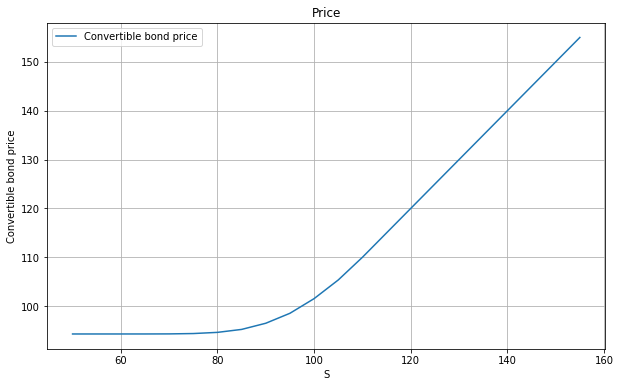

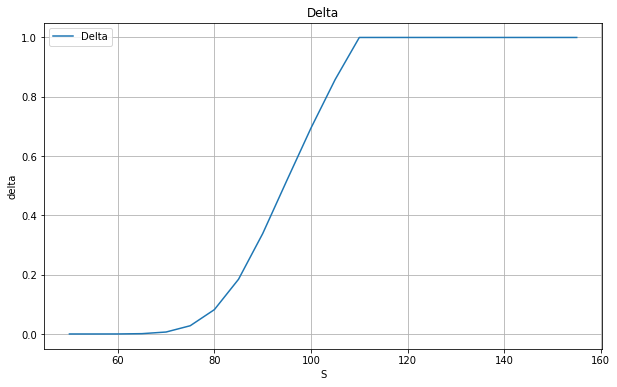

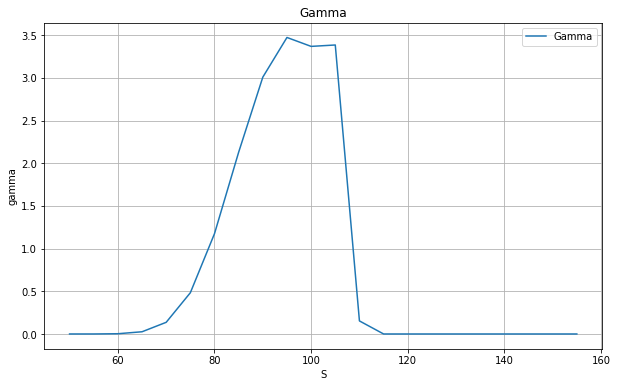

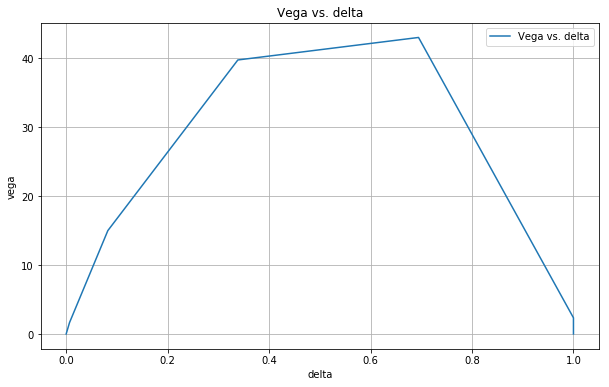

In [5]:
# sensitivities
sensitiv = Sensitivities(pricing)
prices = sensitiv.prices(np.arange(50,160,5))
delta = sensitiv.delta(np.arange(50,160,5))
gamma = sensitiv.gamma(np.arange(50,160,5))
vega_delta = sensitiv.vega_delta(np.arange(50,160,10))

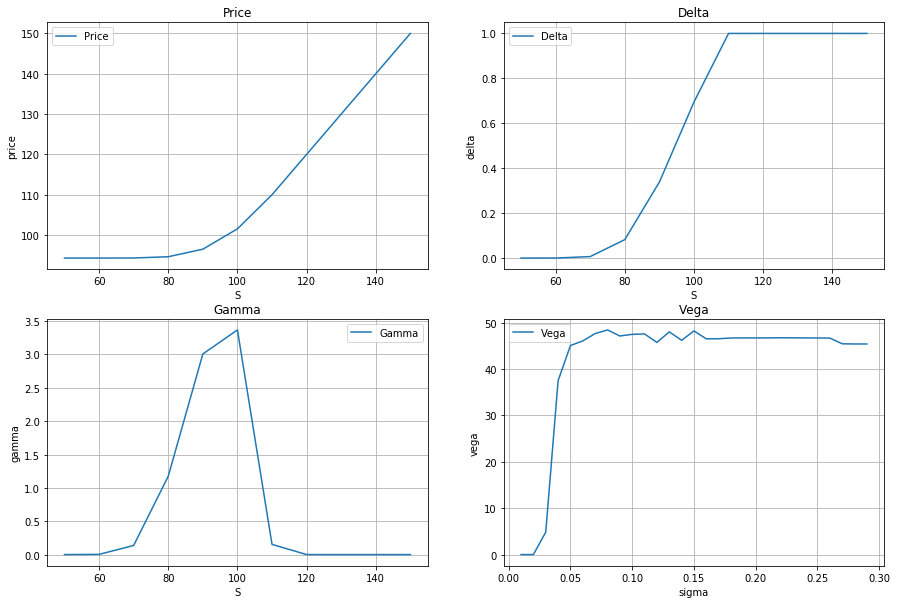

In [6]:
sensitivities = sensitiv.sensitivities_plot(S=np.arange(50,160,10), sigma=np.arange(1,30,1)/100)

### Testing: Valuation class

#### Valuation class

##### Purpose:
This class is used to price the bonds in the data folder and do time series analysis. 

___
__Main functions__:
 - init: Require objects from the class DataUtils
 - price: Price the bond going through the files, can provide a path where to output the result in a csv and add a progress bar to show the remaining bonds to price. Print the isin of the bond that gave errors. Returns the dataframe of the date, price, delta and gamma.
 - compare_results: Return the dataframe comparing prices, delta and gammas to values given in pricing_data_by_isin.csv. If resample (for instance '1W' for weekly data, or '1M' for monthly data) is provided, will resample the data.
 - strategy_implied_delta: Implement the equity implied delta strategy. If resample (for instance '1W' for weekly data, or '1M' for monthly data) is provided, will resample the data.

In [87]:
class ProgressBar(object):
    
    DEFAULT = 'Progress: %(bar)s %(percent)3d%%'
    FULL = '%(bar)s %(current)d/%(total)d (%(percent)3d%%) %(remaining)d to go'

    def __init__(self, total, width=40, fmt=DEFAULT, symbol='=',
                 output=sys.stderr):
        assert len(symbol) == 1

        self.total = total
        self.width = width
        self.symbol = symbol
        self.output = output
        self.fmt = re.sub(r'(?P<name>%\(.+?\))d',
            r'\g<name>%dd' % len(str(total)), fmt)

        self.current = 0

    def __call__(self):
        percent = self.current / float(self.total)
        size = int(self.width * percent)
        remaining = self.total - self.current
        bar = '[' + self.symbol * size + ' ' * (self.width - size) + ']'

        args = {
            'total': self.total,
            'bar': bar,
            'current': self.current,
            'percent': percent * 100,
            'remaining': remaining
        }
        print('\r' + self.fmt % args, file=self.output, end='')

    def done(self):
        self.current = self.total
        self()
        print('', file=self.output)

In [88]:
class Valuation:
    def __init__(self, data_utils):
        """
        Class used to perform time series valuation
        :param data_utils: DataUtils object, with attribute data containing dataframes
        """
        self.data_utils = data_utils
        self.res = None
        self.compare_res = None

    def price(self, path_output=None, progress_bar=True, N_steps=500):
        res = {'date': [], 'isin': [], 'issuer': [], 'price': [], 'delta': [], 'gamma': [],
               'equity_price': []}
        errors = {}
        n = len(self.data_utils.data['pricing_data_by_isin'])
        progress = ProgressBar(n, fmt=ProgressBar.FULL) if progress_bar else None
        # using the pricing_data_by_isin.csv file
        for index, row in self.data_utils.data['pricing_data_by_isin'].iterrows():
            try:
                T = (pd.to_datetime(row.maturity_date) - pd.to_datetime(row.date)).days / 365
                C = row.coupon_annualized / 100
                spr = row.credit_spread / 100 / 100
                if 'isin_cusip_mapping' in self.data_utils.data.keys():
                    conversion_ratio = self.data_utils.data['isin_cusip_mapping'][
                           self.data_utils.data['isin_cusip_mapping']['isin'] == row['isin']].iloc[0]['conversion_ratio'] / 10
                    cusip = self.data_utils.isin_cusip_mapping(isin=row['isin'])
                    notional = self.data_utils.data['isin_cusip_mapping'][
                        self.data_utils.data['isin_cusip_mapping']['isin'] == row['isin']].iloc[0]['par_amt']
                    call_yrs, call_strikes, put_yrs, put_strikes = self.data_utils.put_call_schedule(cusip, row.date)
                else:
                    conversion_ratio = self.data_utils.data['conversion_features_by_isin'][
                                           self.data_utils.data['conversion_features_by_isin']['isin'] == row[
                                               'isin']].iloc[0]['conversion_ratio'] / 10
                    notional = self.data_utils.data['conversion_features_by_isin'][
                        self.data_utils.data['conversion_features_by_isin']['isin'] == row['isin']].iloc[0]['par_amt']
                    call_yrs, call_strikes, put_yrs, put_strikes = None, None, None, None
                isin = row['isin']
                issuer = row.issuer
                S = row.ul_eq_price
                sigma = row.ul_eq_vol / 100
                q = row.ul_eq_divyld / 100
                conv_bond = ConvertibleBondSpec(T, C, spr, conversion_ratio, call_yrs, put_yrs, call_strikes,
                                                put_strikes, notional, isin, issuer)
                stock = StockSpec(sigma, S, q)
                rates_function = self.data_utils.forward_rates(row.date)
                pricing = STTStock(stock, conv_bond, rates_function, N_steps=N_steps)
                result = pricing.price_conv_bond()
                res['date'].append(row.date)
                res['isin'].append(isin)
                res['issuer'].append(issuer)
                res['price'].append(result['price'])
                res['delta'].append(result['delta'])
                res['gamma'].append(result['gamma'])
                res['equity_price'].append(S)
            except Exception as e:
                errors[row['isin']] = e
            if progress and index % (n // 100) == 0:
                progress.current = index
                progress()
        if progress:
            progress.done()
        res = pd.DataFrame(res)
        if path_output:
            res.to_csv(path_output)
        print('# Errors #')
        print(errors.keys())

        self.res = res
        return res

    @staticmethod
    def resample_data(res, freq):
        res.index = pd.to_datetime(res['date'])
        res.sort_index(inplace=True)
        return res.resample(freq).last().reset_index(drop=True)

    def compare_results(self, plot=True, resample=None, plot_xlabel=False):
        """

        :param plot:
        :param resample:
        :param plot_xlabel: in PyCharm or Jupyter lab, indexing of xlabels takes a lot of time, use plot_xlabel=False
        to have the code run, it should work with plot_xlabel=True in Jupyter notebook
        :return:
        """
        data = self.data_utils.data['pricing_data_by_isin']
        data = data[['date', 'isin', 'convertible_price',
                     'delta', 'gamma']].rename(columns={'convertible_price': 'convertible_price_given',
                                                        'delta': 'delta_given', 'gamma': 'gamma_given'})
        res = self.res.merge(data, left_on=['date', 'isin'], right_on=['date', 'isin'], how='inner')
        res['delta_given'] = res['delta_given'] / 100
        if resample:
            res = self.resample_data(res, resample)

        if plot:
            for e in res['isin'].unique():
                try:
                    temp_df = res[res['isin'] == e].set_index('date').sort_index()
                    issuer = temp_df['issuer'].iloc[0]
                    print('# Issuer: {} #'.format(issuer))
                    if plot_xlabel:
                        fig = plt.figure(figsize=(20, 5))
                        ax = fig.add_subplot(131)
                        ax.plot(temp_df.index, temp_df['price'], label='Model price')
                        ax.plot(temp_df.index, temp_df['convertible_price_given'], label='Market price')
                        plt.xticks(temp_df.index[::int(len(temp_df) * .95) // 5],
                                   [str(e)[:7] for e in temp_df.index[::int(len(temp_df) * .95) // 5]])

                        plt.xlabel('Date')
                        plt.ylabel('Price')
                        plt.title('Prices')
                        plt.legend()
                        plt.grid()

                        ax = fig.add_subplot(132)
                        ax.plot(temp_df.index, temp_df['delta'], label='Model delta')
                        ax.plot(temp_df.index, temp_df['delta_given'], label='Market delta')
                        plt.xticks(temp_df.index[::int(len(temp_df) * .95) // 5],
                                   [str(e)[:7] for e in temp_df.index[::int(len(temp_df) * .95) // 5]])
                        plt.ylim((0., 1.05))
                        plt.xlabel('Date')
                        plt.ylabel('Delta')
                        plt.title('Delta')
                        plt.legend()
                        plt.grid()

                        ax = fig.add_subplot(133)
                        ax.plot(temp_df.index, temp_df['gamma'], label='Model gamma')
                        ax.plot(temp_df.index, temp_df['gamma_given'], label='Market gamma')
                        plt.xticks(temp_df.index[::int(len(temp_df) * .95) // 5],
                                   [str(e)[:7] for e in temp_df.index[::int(len(temp_df) * .95) // 5]])
                        plt.xlabel('Date')
                        plt.ylabel('Gamma')
                        plt.title('Gamma')
                        plt.legend()
                        plt.grid()
                        plt.show()
                    else:
                        fig = plt.figure(figsize=(20, 5))
                        ax = fig.add_subplot(131)
                        ax.plot(temp_df['price'], label='Model price')
                        ax.plot(temp_df['convertible_price_given'], label='Market price')
                        plt.xticks([])

                        plt.xlabel('Date')
                        plt.ylabel('Price')
                        plt.title('Prices')
                        plt.legend()
                        plt.grid()

                        ax = fig.add_subplot(132)
                        ax.plot(temp_df['delta'], label='Model delta')
                        ax.plot(temp_df['delta_given'], label='Market delta')
                        plt.xticks([])

                        plt.ylim((0., 1.05))
                        plt.xlabel('Date')
                        plt.ylabel('Delta')
                        plt.title('Delta')
                        plt.legend()
                        plt.grid()

                        ax = fig.add_subplot(133)
                        ax.plot(temp_df['gamma'], label='Model gamma')
                        ax.plot(temp_df['gamma_given'], label='Market gamma')
                        plt.xticks([])

                        plt.xlabel('Date')
                        plt.ylabel('Gamma')
                        plt.title('Gamma')
                        plt.legend()
                        plt.grid()
                        plt.show()
                except:
                    print('Error: ', issuer)
                    pass

        self.compare_res = res
        return self.compare_res

In [89]:
path =  'C:/Users/manas/Notebooks/Converts/cbv_utils/data_batch2/'
data_utils = DataUtils(path)
data_utils.load()
valuation = Valuation(data_utils)
path_output = path + 'test_valuation500steps.csv'

#--- Loading conversion_features_by_isin.csv ---#
#--- Loading conversion.csv ---#
#--- Loading convert_sched.csv ---#
#--- Loading interest_rate_term_structure.csv ---#
#--- Loading isin_cusip_mapping.csv ---#
#--- Loading pricing_data_by_isin.csv ---#
#--- Loading put_call_info.csv ---#
#--- Loading put_call_schedule.csv ---#


In [91]:
# compute the prices for all the bond and save the result in a file in csv format
res = valuation.price(path_output, progress_bar=True, N_steps=500)

[======================================= ] 1890/1894 ( 99%)    4 to go

# Errors #
dict_keys(['US88160RAB78'])


[========================================] 1894/1894 (100%)    0 to go


In [64]:
# # if the file already exists, upload it directly to save time
# valuation.res = pd.read_csv(path_output)

# Issuer: Advanced Micro #


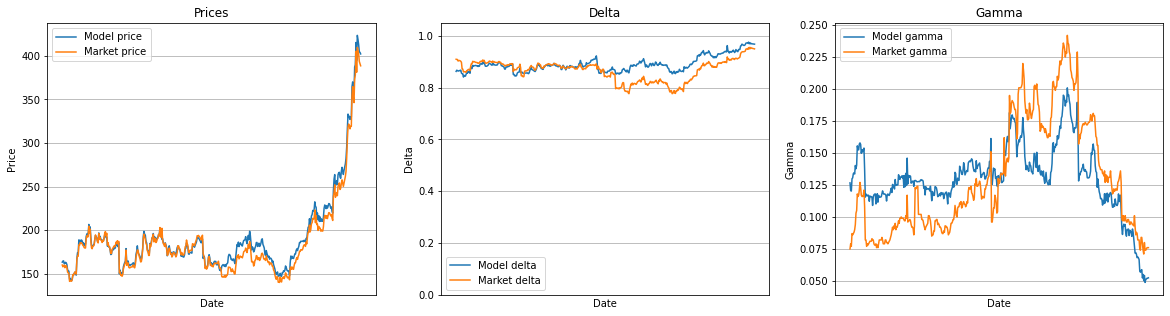

# Issuer: J2 Global Inc #


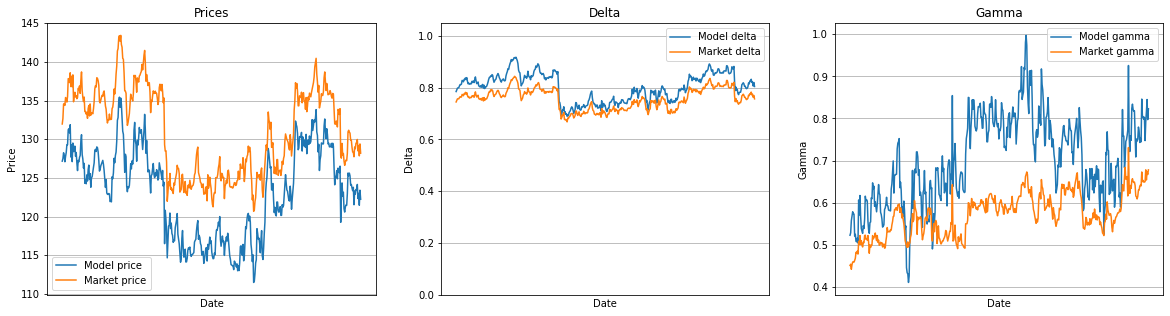

# Issuer: Micron Tech `G` #


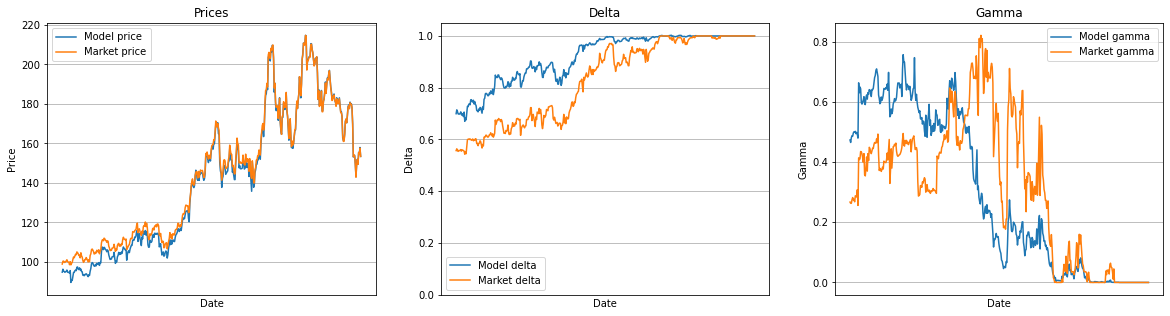

# Issuer: Stillwater Mining #


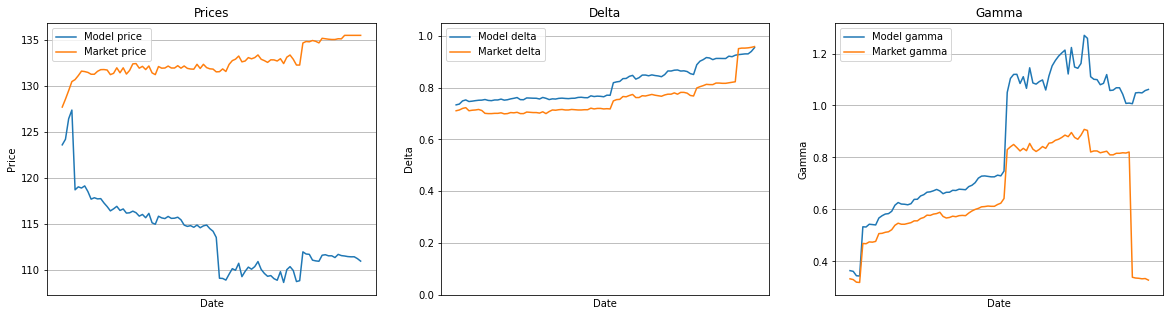

# Issuer: Tesla Motors #


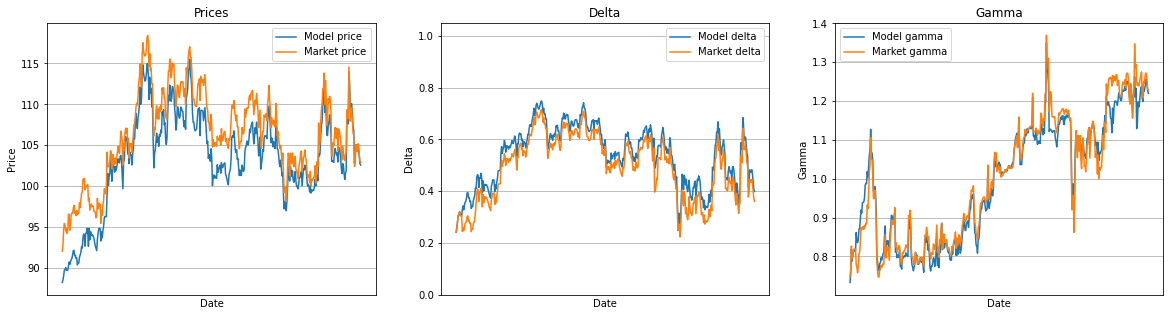

In [92]:
# if plot takes too much time, use plot_xlabel=False
res = valuation.compare_results(plot_xlabel=False)

In [59]:
# valuation.trading(.01, -.01, .005, -.005, plot_xlabel=True)

In [60]:
# res = valuation.strategy_implied_delta(plot_xlabel=True)

# Additional examples

In [2]:
# valuation on batch 1
path = '/Users/teddylegros/Documents/Cours/MFE/Courses/Independent study/BlackRock - Convertible Bond/ConvBondVal/cbv_utils/data_batch1/'
data_utils = DataUtils(path)
data_utils.load()
valuation = Valuation(data_utils)
path_output = path + 'test_valuation500steps.csv'
res = valuation.price(path_output, progress_bar=True, N_steps=500)

#--- Loading conversion_features_by_isin.csv ---#
#--- Loading conversion.csv ---#
### Error loading conversion.csv ###
Verify that the format is correct and that the file is located in the folder
#--- Loading convert_sched.csv ---#
### Error loading convert_sched.csv ###
Verify that the format is correct and that the file is located in the folder
#--- Loading interest_rate_term_structure.csv ---#
#--- Loading isin_cusip_mapping.csv ---#
### Error loading isin_cusip_mapping.csv ###
Verify that the format is correct and that the file is located in the folder
#--- Loading pricing_data_by_isin.csv ---#
#--- Loading put_call_info.csv ---#
### Error loading put_call_info.csv ###
Verify that the format is correct and that the file is located in the folder
#--- Loading put_call_schedule.csv ---#
### Error loading put_call_schedule.csv ###
Verify that the format is correct and that the file is located in the folder


[======================================= ] 1122/1128 ( 99%)    6 to go

# Errors #
dict_keys(['US88160RAB78'])


[========================================] 1128/1128 (100%)    0 to go


# Issuer: Advanced Micro #


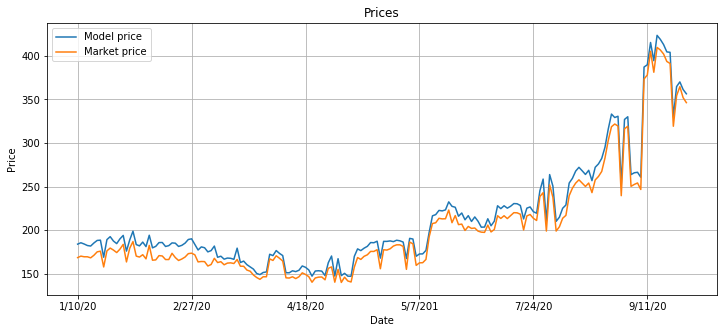

# Issuer: Intel Corp #


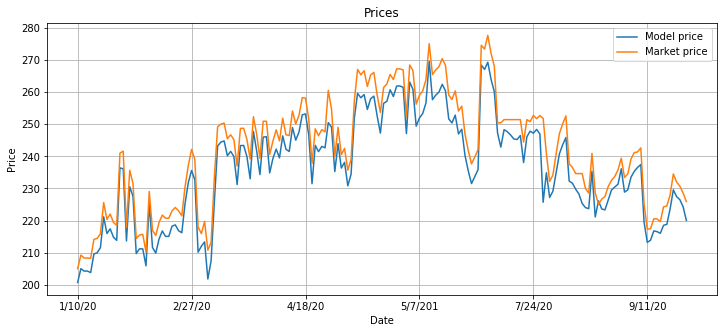

# Issuer: Tesla #


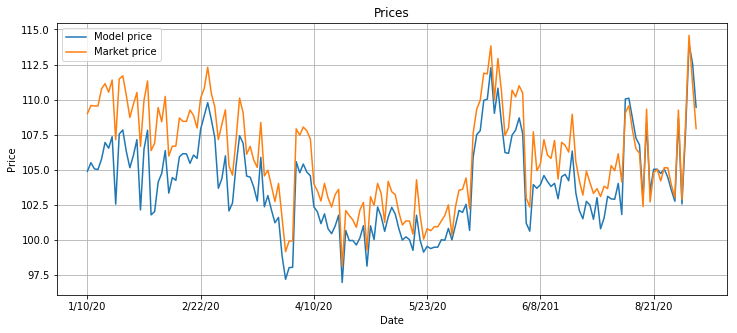

# Issuer: Tesla #


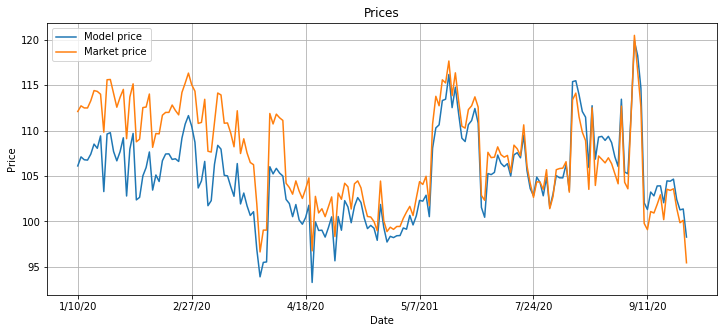

# Issuer: Tesla #


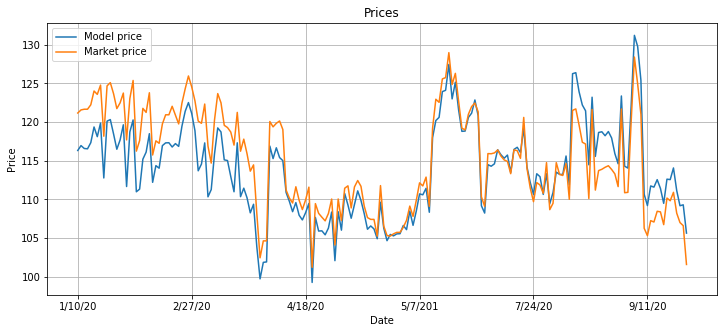

# Issuer: Whiting Petroleum #


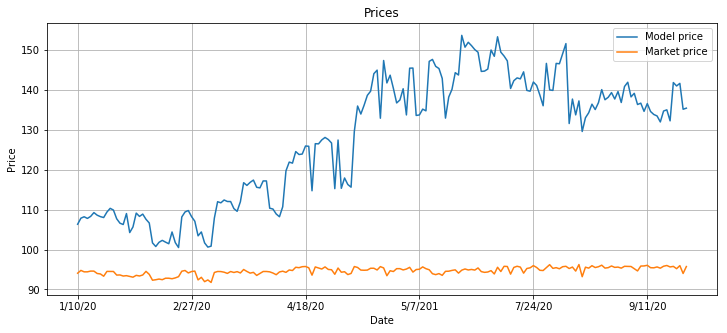

In [16]:
# just plot the prices, the delta and gammas are not given in the file
# compare_results() will not work
res = valuation.res.merge(data_utils.data['pricing_data_by_isin'][
    ['date', 'isin', 'convertible_price']].rename(columns={'convertible_price': 'convertible_price_given'}), 
                          left_on=['date', 'isin'], right_on=['date', 'isin'], how='inner')
for e in res['isin'].unique():
    temp_df = res[res['isin'] == e].set_index('date').sort_index()
    issuer = temp_df['issuer'].iloc[0]
    print('# Issuer: {} #'.format(issuer))
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    ax.plot(temp_df.index, temp_df['price'], label='Model price')
    ax.plot(temp_df.index, temp_df['convertible_price_given'], label='Market price')
    plt.xticks(temp_df.index[::int(len(temp_df) * .95) // 5],
               [str(e)[:7] for e in temp_df.index[::int(len(temp_df) * .95) // 5]])
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Prices')
    plt.legend()
    plt.grid()
    plt.show()

# Issuer: Advanced Micro #


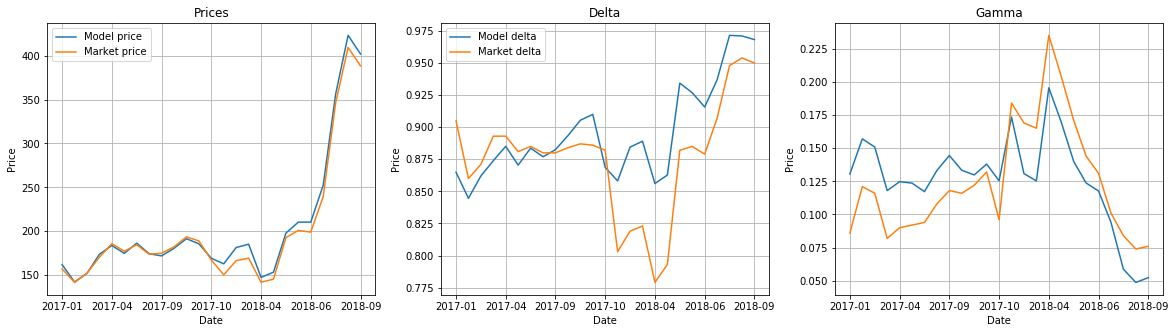

# Issuer: Tesla Motors #


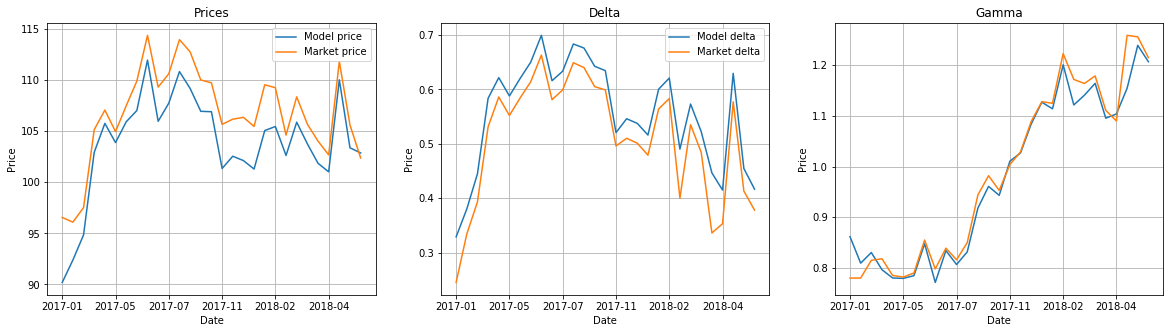

# Issuer: Micron Tech `G` #


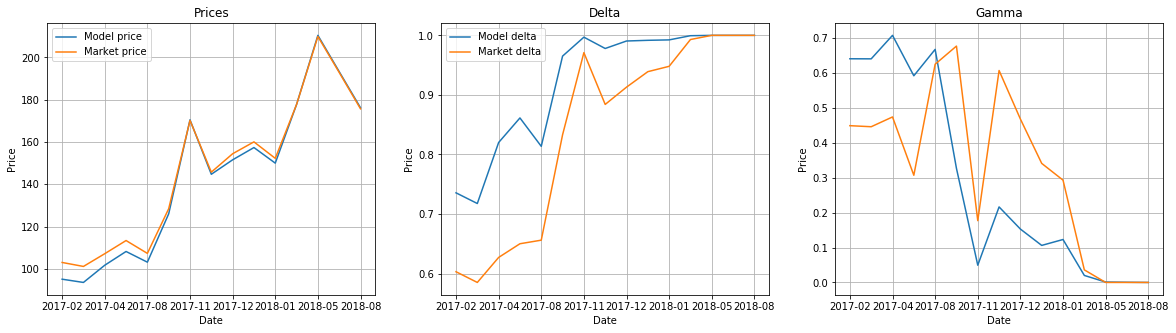

# Issuer: J2 Global Inc #


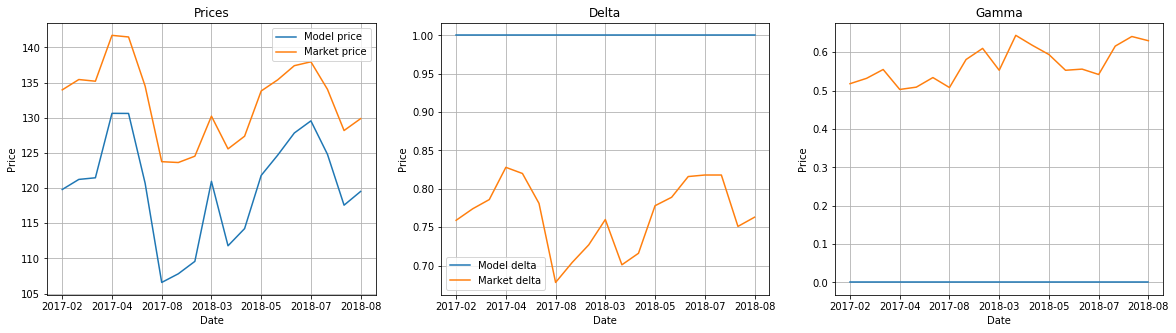

# Issuer: Stillwater Mining #
Error:  Stillwater Mining


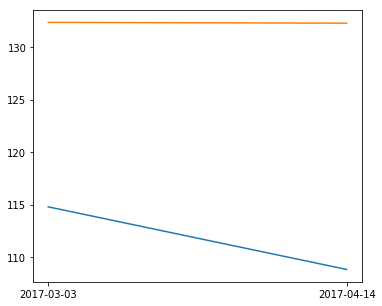

In [6]:
# resampling the data to week frequency (for month frequency, use '1M')
res = valuation.compare_results(resample='1W')

# Issuer: Advanced Micro #


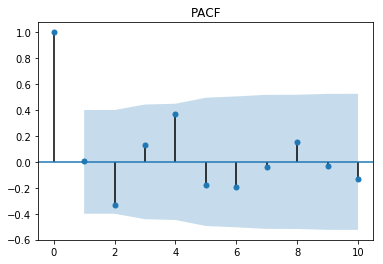

ADF test:  -4.43938344437058 p-value  0.00025265171383667033


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<Figure size 576x432 with 0 Axes>

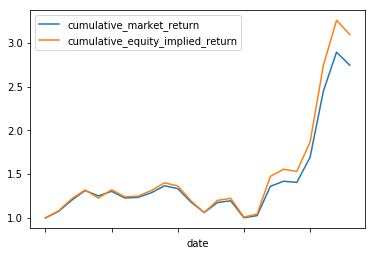

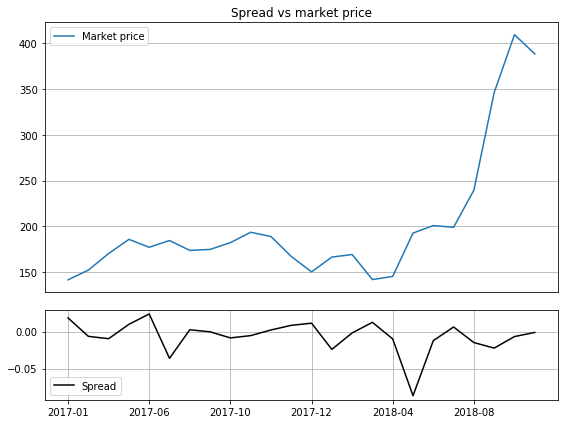

# Issuer: Tesla Motors #


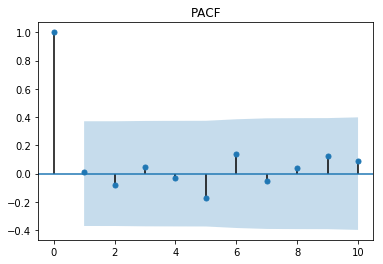

ADF test:  -4.875037078294757 p-value  3.899357655807902e-05


<Figure size 576x432 with 0 Axes>

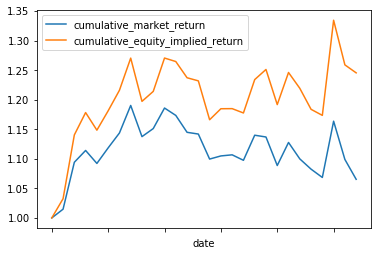

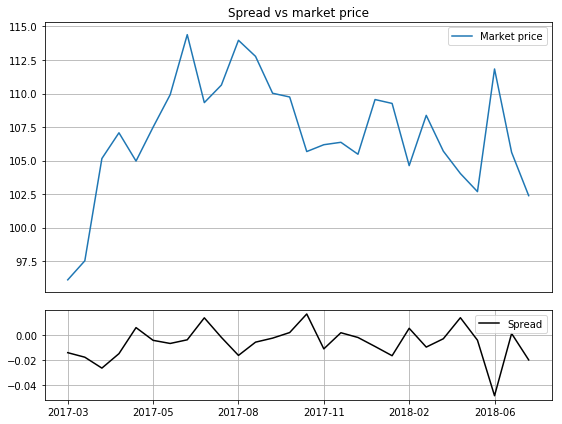

# Issuer: Micron Tech `G` #


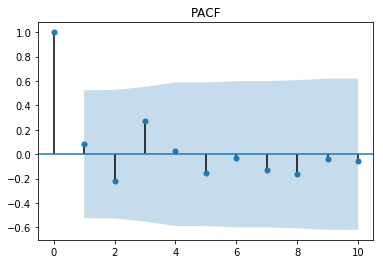

ADF test:  -3.062061962422184 p-value  0.029491166240656858


<Figure size 576x432 with 0 Axes>

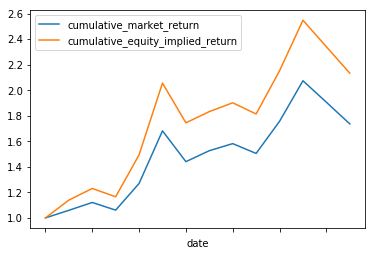

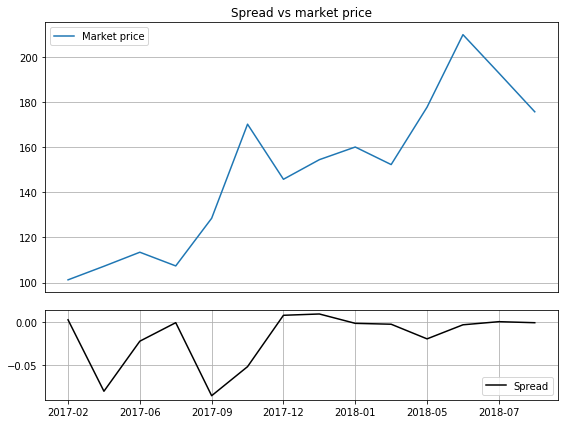

# Issuer: J2 Global Inc #


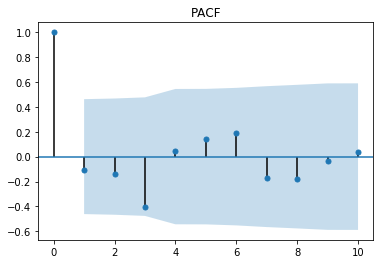

ADF test:  -4.315212773836714 p-value  0.0004180250957008997


<Figure size 576x432 with 0 Axes>

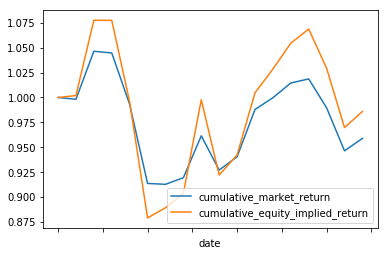

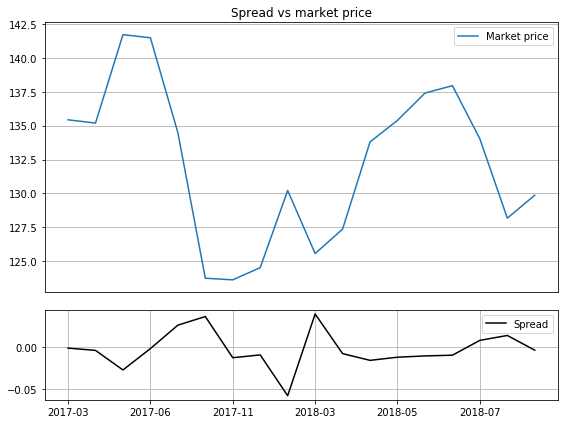

# Issuer: Stillwater Mining #


TypeError: len() of unsized object

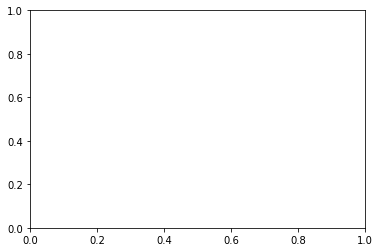

In [7]:
res = valuation.strategy_implied_delta(resample='1W')